# AG News - Evaluation Pipeline

**Task**: Single-label News Topic Classification  
**Objective**: Comprehensive model evaluation and comparison  

---

## Pipeline Overview

1. Environment Setup
2. Load Trained Models
3. Detailed Metrics Computation
4. Confusion Matrix Analysis
5. Per-Class Performance Analysis
6. Inference Speed Benchmarking
7. Statistical Significance Testing
8. Generate Evaluation Report

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [2]:
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print("✅ All imports successful!")

✅ Using device: cuda
✅ All imports successful!


In [3]:
class EvalConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    EVAL_DIR = './evaluation'
    
    MODELS = {
        'bert-base': 'ag_news_bert-base_best',
        'distilbert': 'ag_news_distilbert_best',
        'tinybert': 'ag_news_tinybert_best'
    }
    
    LABEL_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
    NUM_LABELS = 4
    
    BATCH_SIZE = 32
    
    BENCHMARK_SAMPLES = 1000
    WARMUP_RUNS = 10
    BENCHMARK_RUNS = 100

config = EvalConfig()

os.makedirs(config.EVAL_DIR, exist_ok=True)

print("📋 Evaluation Configuration loaded!")

📋 Evaluation Configuration loaded!


## 2. Load Trained Models & Data

In [4]:
print("📥 Loading test dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'ag_news_tokenized')
dataset = load_from_disk(dataset_path)
test_dataset = dataset['test']

print(f"✅ Test dataset loaded: {len(test_dataset):,} samples")

📥 Loading test dataset...
✅ Test dataset loaded: 7,600 samples


In [5]:
def load_model_and_tokenizer(model_name):
    """
    Load a trained model and its tokenizer.
    """
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    
    print(f"📦 Loading {model_name} from {model_path}...")
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    
    return model, tokenizer

models = {}
tokenizers = {}

for model_name in config.MODELS.keys():
    models[model_name], tokenizers[model_name] = load_model_and_tokenizer(model_name)

print("\n✅ All models loaded!")

📦 Loading bert-base from ./models/ag_news_bert-base_best...
📦 Loading distilbert from ./models/ag_news_distilbert_best...
📦 Loading tinybert from ./models/ag_news_tinybert_best...

✅ All models loaded!


## 3. Detailed Metrics Computation

In [6]:
@torch.no_grad()
def get_predictions(model, dataset, batch_size=32):
    """
    Get predictions for the entire dataset.
    
    Returns:
        predictions: numpy array of predicted labels
        probabilities: numpy array of class probabilities
        true_labels: numpy array of true labels
    """
    model.eval()
    
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_probabilities.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)

print("🔄 Getting predictions for all models...")

predictions = {}
probabilities = {}
true_labels = None

for model_name, model in models.items():
    print(f"   Processing {model_name}...")
    preds, probs, labels = get_predictions(model, test_dataset, config.BATCH_SIZE)
    predictions[model_name] = preds
    probabilities[model_name] = probs
    if true_labels is None:
        true_labels = labels

print("\n✅ All predictions computed!")

🔄 Getting predictions for all models...
   Processing bert-base...
   Processing distilbert...
   Processing tinybert...

✅ All predictions computed!


In [7]:
def compute_detailed_metrics(y_true, y_pred, y_prob, label_names):
    """
    Compute comprehensive metrics for classification.
    """
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro')
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    
    metrics['per_class'] = {}
    for i, label in enumerate(label_names):
        mask = (y_true == i)
        class_pred = (y_pred == i)
        
        metrics['per_class'][label] = {
            'precision': precision_score(y_true == i, y_pred == i),
            'recall': recall_score(y_true == i, y_pred == i),
            'f1': f1_score(y_true == i, y_pred == i),
            'support': mask.sum()
        }
    
    try:
        metrics['roc_auc_macro'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        metrics['roc_auc_weighted'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    except:
        metrics['roc_auc_macro'] = None
        metrics['roc_auc_weighted'] = None
    
    return metrics

all_metrics = {}
for model_name in predictions.keys():
    print(f"\n📊 Computing metrics for {model_name}...")
    all_metrics[model_name] = compute_detailed_metrics(
        true_labels,
        predictions[model_name],
        probabilities[model_name],
        config.LABEL_NAMES
    )

print("\n✅ All metrics computed!")


📊 Computing metrics for bert-base...

📊 Computing metrics for distilbert...

📊 Computing metrics for tinybert...

✅ All metrics computed!


In [8]:
metrics_comparison = []
for model_name, metrics in all_metrics.items():
    metrics_comparison.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1 (Macro)': f"{metrics['f1_macro']:.4f}",
        'F1 (Weighted)': f"{metrics['f1_weighted']:.4f}",
        'Precision': f"{metrics['precision_macro']:.4f}",
        'Recall': f"{metrics['recall_macro']:.4f}",
        'ROC AUC': f"{metrics['roc_auc_macro']:.4f}" if metrics['roc_auc_macro'] else 'N/A'
    })

metrics_df = pd.DataFrame(metrics_comparison)
print("\n📊 Overall Metrics Comparison:")
print("="*80)
print(metrics_df.to_string(index=False))


📊 Overall Metrics Comparison:
     Model Accuracy F1 (Macro) F1 (Weighted) Precision Recall ROC AUC
 bert-base   0.9408     0.9408        0.9408    0.9412 0.9408  0.9924
distilbert   0.9387     0.9387        0.9387    0.9389 0.9387  0.9923
  tinybert   0.9242     0.9241        0.9241    0.9245 0.9242  0.9888


In [9]:
for model_name in predictions.keys():
    print(f"\n{'='*60}")
    print(f"📋 Classification Report: {model_name.upper()}")
    print(f"{'='*60}")
    print(classification_report(
        true_labels,
        predictions[model_name],
        target_names=config.LABEL_NAMES,
        digits=4
    ))


📋 Classification Report: BERT-BASE
              precision    recall  f1-score   support

       World     0.9502    0.9542    0.9522      1900
      Sports     0.9857    0.9826    0.9842      1900
    Business     0.9317    0.8900    0.9104      1900
    Sci/Tech     0.8971    0.9363    0.9163      1900

    accuracy                         0.9408      7600
   macro avg     0.9412    0.9408    0.9408      7600
weighted avg     0.9412    0.9408    0.9408      7600


📋 Classification Report: DISTILBERT
              precision    recall  f1-score   support

       World     0.9516    0.9526    0.9521      1900
      Sports     0.9847    0.9832    0.9839      1900
    Business     0.9198    0.8937    0.9066      1900
    Sci/Tech     0.8992    0.9253    0.9121      1900

    accuracy                         0.9387      7600
   macro avg     0.9389    0.9387    0.9387      7600
weighted avg     0.9389    0.9387    0.9387      7600


📋 Classification Report: TINYBERT
              precisio

## 4. Confusion Matrix Analysis

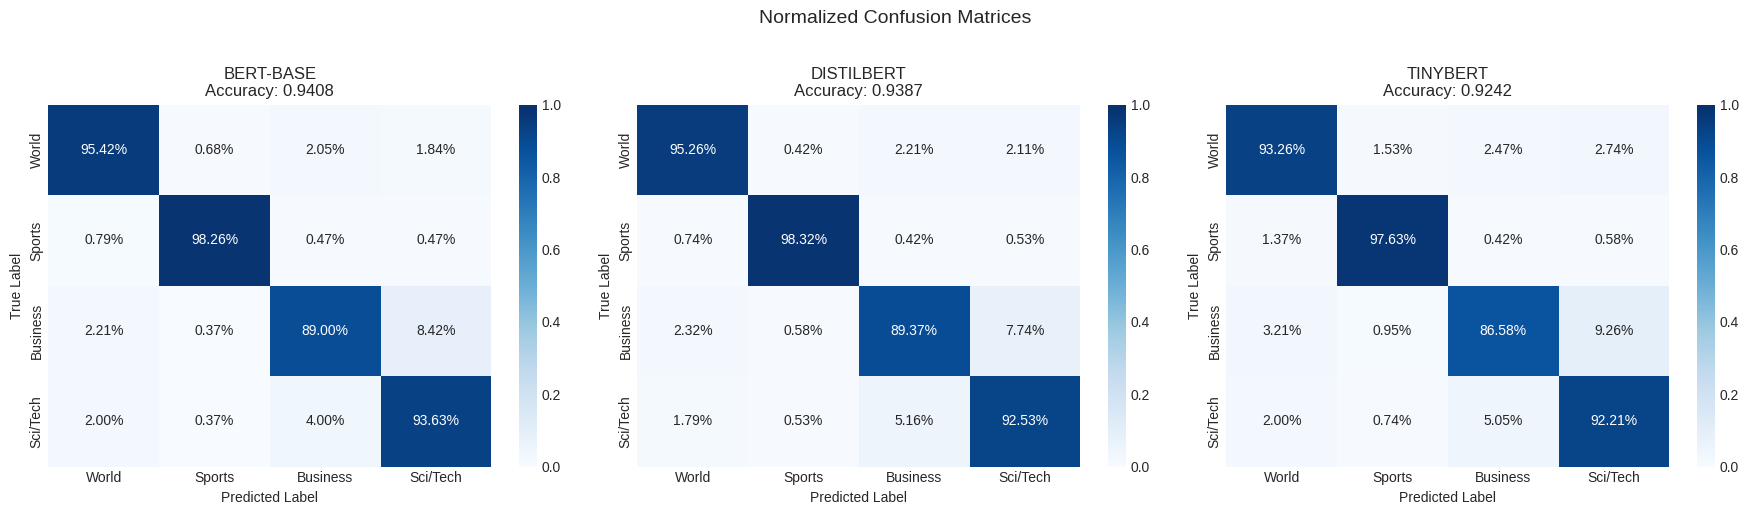

In [10]:
def plot_confusion_matrices(predictions_dict, true_labels, label_names):
    """
    Plot confusion matrices for all models.
    """
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, preds) in zip(axes, predictions_dict.items()):
        cm = confusion_matrix(true_labels, preds)
        
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt='.2%',
            cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            ax=ax,
            vmin=0,
            vmax=1
        )
        
        ax.set_title(f'{model_name.upper()}\nAccuracy: {accuracy_score(true_labels, preds):.4f}', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=10)
        ax.set_ylabel('True Label', fontsize=10)
    
    plt.suptitle('Normalized Confusion Matrices', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.EVAL_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
    plt.show()

plot_confusion_matrices(predictions, true_labels, config.LABEL_NAMES)

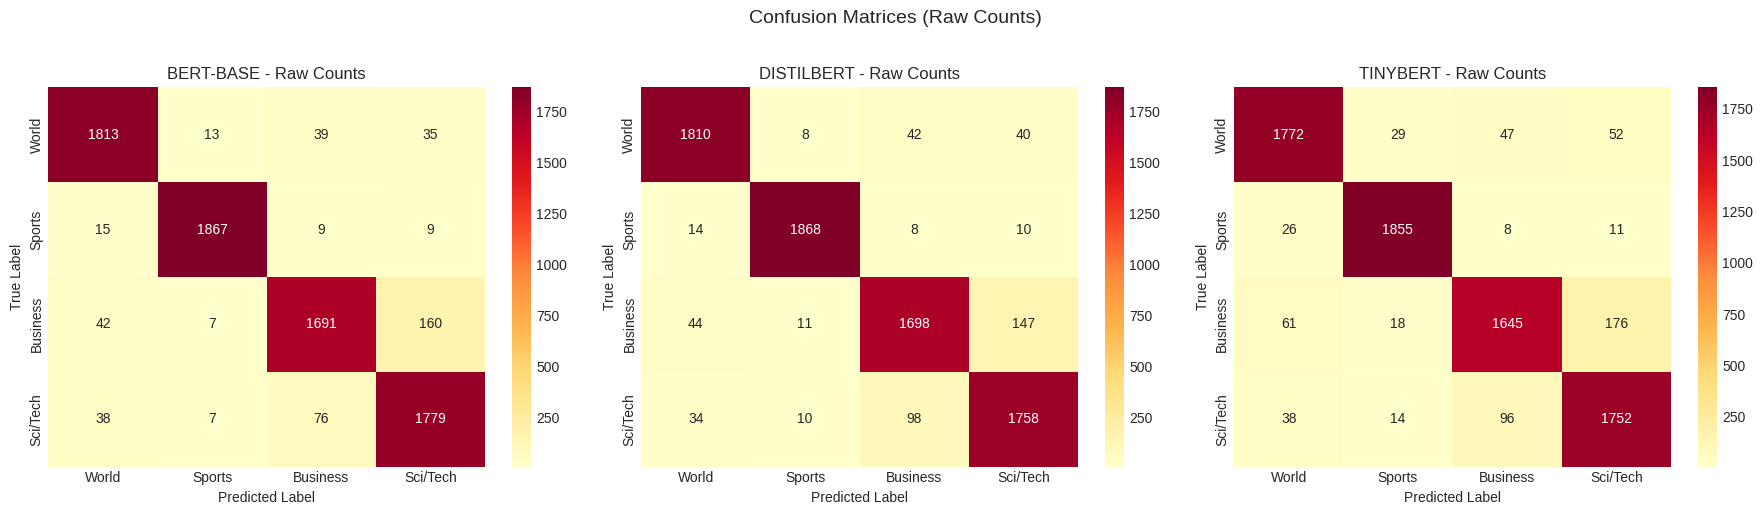

In [11]:
def plot_raw_confusion_matrices(predictions_dict, true_labels, label_names):
    """
    Plot confusion matrices with raw counts.
    """
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, preds) in zip(axes, predictions_dict.items()):
        cm = confusion_matrix(true_labels, preds)
        
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='YlOrRd',
            xticklabels=label_names,
            yticklabels=label_names,
            ax=ax
        )
        
        ax.set_title(f'{model_name.upper()} - Raw Counts', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=10)
        ax.set_ylabel('True Label', fontsize=10)
    
    plt.suptitle('Confusion Matrices (Raw Counts)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.EVAL_DIR, 'confusion_matrices_raw.png'), dpi=150, bbox_inches='tight')
    plt.show()

plot_raw_confusion_matrices(predictions, true_labels, config.LABEL_NAMES)

## 5. Per-Class Performance Analysis

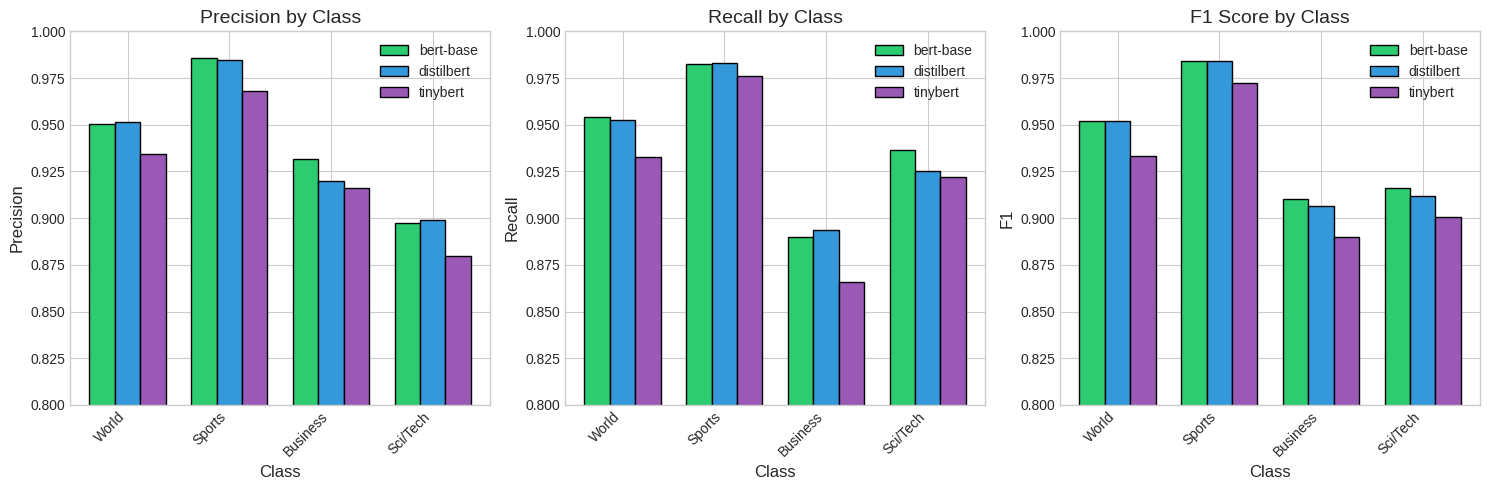

In [12]:
def plot_per_class_metrics(all_metrics, label_names):
    """
    Plot per-class performance metrics.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    metrics_to_plot = ['precision', 'recall', 'f1']
    titles = ['Precision by Class', 'Recall by Class', 'F1 Score by Class']
    
    x = np.arange(len(label_names))
    width = 0.25
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    
    for ax, metric, title in zip(axes, metrics_to_plot, titles):
        for i, (model_name, metrics) in enumerate(all_metrics.items()):
            values = [metrics['per_class'][label][metric] for label in label_names]
            ax.bar(x + i*width, values, width, label=model_name, color=colors[i], edgecolor='black')
        
        ax.set_xlabel('Class', fontsize=12)
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_xticks(x + width)
        ax.set_xticklabels(label_names, rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0.8, 1.0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.EVAL_DIR, 'per_class_metrics.png'), dpi=150, bbox_inches='tight')
    plt.show()

plot_per_class_metrics(all_metrics, config.LABEL_NAMES)

In [13]:
print("\n📊 Per-Class Performance Comparison:")
print("="*80)

for label in config.LABEL_NAMES:
    print(f"\n📌 {label}:")
    class_data = []
    for model_name, metrics in all_metrics.items():
        class_metrics = metrics['per_class'][label]
        class_data.append({
            'Model': model_name,
            'Precision': f"{class_metrics['precision']:.4f}",
            'Recall': f"{class_metrics['recall']:.4f}",
            'F1': f"{class_metrics['f1']:.4f}",
            'Support': class_metrics['support']
        })
    print(pd.DataFrame(class_data).to_string(index=False))


📊 Per-Class Performance Comparison:

📌 World:
     Model Precision Recall     F1  Support
 bert-base    0.9502 0.9542 0.9522     1900
distilbert    0.9516 0.9526 0.9521     1900
  tinybert    0.9341 0.9326 0.9334     1900

📌 Sports:
     Model Precision Recall     F1  Support
 bert-base    0.9857 0.9826 0.9842     1900
distilbert    0.9847 0.9832 0.9839     1900
  tinybert    0.9682 0.9763 0.9722     1900

📌 Business:
     Model Precision Recall     F1  Support
 bert-base    0.9317 0.8900 0.9104     1900
distilbert    0.9198 0.8937 0.9066     1900
  tinybert    0.9159 0.8658 0.8902     1900

📌 Sci/Tech:
     Model Precision Recall     F1  Support
 bert-base    0.8971 0.9363 0.9163     1900
distilbert    0.8992 0.9253 0.9121     1900
  tinybert    0.8800 0.9221 0.9005     1900


## 6. Inference Speed Benchmarking

In [14]:
@torch.no_grad()
def benchmark_inference(model, dataset, num_samples=100, warmup_runs=10, benchmark_runs=100):
    """
    Benchmark inference speed.
    
    Returns:
        dict: timing statistics
    """
    model.eval()
    
    sample_data = dataset.select(range(min(num_samples, len(dataset))))
    
    input_ids = torch.tensor(sample_data['input_ids']).to(device)
    attention_mask = torch.tensor(sample_data['attention_mask']).to(device)
    
    for _ in range(warmup_runs):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    times = []
    for _ in range(benchmark_runs):
        start = time.perf_counter()
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end = time.perf_counter()
        times.append(end - start)
    
    times = np.array(times)
    samples_per_second = num_samples / times.mean()
    
    return {
        'mean_time_ms': times.mean() * 1000,
        'std_time_ms': times.std() * 1000,
        'min_time_ms': times.min() * 1000,
        'max_time_ms': times.max() * 1000,
        'samples_per_second': samples_per_second,
        'ms_per_sample': (times.mean() * 1000) / num_samples
    }

print("⏱️ Benchmarking inference speed...")
print(f"   Samples: {config.BENCHMARK_SAMPLES}")
print(f"   Warmup runs: {config.WARMUP_RUNS}")
print(f"   Benchmark runs: {config.BENCHMARK_RUNS}")

benchmark_results = {}
for model_name, model in models.items():
    print(f"\n   Benchmarking {model_name}...")
    benchmark_results[model_name] = benchmark_inference(
        model, test_dataset,
        num_samples=config.BENCHMARK_SAMPLES,
        warmup_runs=config.WARMUP_RUNS,
        benchmark_runs=config.BENCHMARK_RUNS
    )

print("\n✅ Benchmarking complete!")

⏱️ Benchmarking inference speed...
   Samples: 1000
   Warmup runs: 10
   Benchmark runs: 100

   Benchmarking bert-base...


TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
benchmark_df = pd.DataFrame([
    {
        'Model': name,
        'Mean Time (ms)': f"{results['mean_time_ms']:.2f}",
        'Std Time (ms)': f"{results['std_time_ms']:.2f}",
        'Samples/sec': f"{results['samples_per_second']:.1f}",
        'ms/sample': f"{results['ms_per_sample']:.3f}"
    }
    for name, results in benchmark_results.items()
])

print("\n⏱️ Inference Speed Comparison:")
print("="*70)
print(benchmark_df.to_string(index=False))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

model_names = list(benchmark_results.keys())
colors = ['#2ecc71', '#3498db', '#9b59b6']

samples_per_sec = [benchmark_results[m]['samples_per_second'] for m in model_names]
bars1 = axes[0].bar(model_names, samples_per_sec, color=colors, edgecolor='black')
axes[0].set_ylabel('Samples per Second', fontsize=12)
axes[0].set_title('Inference Throughput', fontsize=14)
for bar, val in zip(bars1, samples_per_sec):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{val:.0f}', ha='center', va='bottom', fontsize=10)

ms_per_sample = [benchmark_results[m]['ms_per_sample'] for m in model_names]
bars2 = axes[1].bar(model_names, ms_per_sample, color=colors, edgecolor='black')
axes[1].set_ylabel('Milliseconds per Sample', fontsize=12)
axes[1].set_title('Inference Latency', fontsize=14)
for bar, val in zip(bars2, ms_per_sample):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'inference_speed.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Model Efficiency Analysis

In [ ]:
training_results_path = os.path.join(config.LOG_DIR, 'training_results.json')

try:
    with open(training_results_path, 'r') as f:
        training_results = json.load(f)
    print("✅ Training results loaded!")
except FileNotFoundError:
    print("⚠️ Training results not found. Using placeholder values.")
    training_results = {
        'bert-base': {'total_params': 109000000, 'size_mb': 418, 'training_time_minutes': 30},
        'distilbert': {'total_params': 66000000, 'size_mb': 253, 'training_time_minutes': 18},
        'tinybert': {'total_params': 14500000, 'size_mb': 55, 'training_time_minutes': 10}
    }

In [ ]:
efficiency_data = []
for model_name in model_names:
    train_info = training_results.get(model_name, {})
    benchmark_info = benchmark_results[model_name]
    metrics_info = all_metrics[model_name]
    
    efficiency_data.append({
        'Model': model_name,
        'Parameters (M)': train_info.get('total_params', 0) / 1e6,
        'Size (MB)': train_info.get('size_mb', 0),
        'Train Time (min)': train_info.get('training_time_minutes', 0),
        'Throughput (samples/s)': benchmark_info['samples_per_second'],
        'Accuracy': metrics_info['accuracy'],
        'F1 Macro': metrics_info['f1_macro']
    })

efficiency_df = pd.DataFrame(efficiency_data)

efficiency_df['Accuracy/Param'] = efficiency_df['Accuracy'] / efficiency_df['Parameters (M)']
efficiency_df['Accuracy/Size'] = efficiency_df['Accuracy'] / efficiency_df['Size (MB)']

print("\n📊 Model Efficiency Analysis:")
print("="*90)
print(efficiency_df.round(4).to_string(index=False))

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#2ecc71', '#3498db', '#9b59b6']

ax = axes[0, 0]
scatter = ax.scatter(
    efficiency_df['Parameters (M)'],
    efficiency_df['Accuracy'],
    s=300, c=colors, edgecolor='black', linewidth=2
)
for i, row in efficiency_df.iterrows():
    ax.annotate(row['Model'], (row['Parameters (M)'], row['Accuracy']),
               textcoords="offset points", xytext=(0, 12), ha='center', fontsize=10)
ax.set_xlabel('Parameters (Millions)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Parameters vs Accuracy Trade-off', fontsize=14)

ax = axes[0, 1]
ax.scatter(
    efficiency_df['Size (MB)'],
    efficiency_df['Throughput (samples/s)'],
    s=300, c=colors, edgecolor='black', linewidth=2
)
for i, row in efficiency_df.iterrows():
    ax.annotate(row['Model'], (row['Size (MB)'], row['Throughput (samples/s)']),
               textcoords="offset points", xytext=(0, 12), ha='center', fontsize=10)
ax.set_xlabel('Model Size (MB)', fontsize=12)
ax.set_ylabel('Throughput (samples/s)', fontsize=12)
ax.set_title('Size vs Speed Trade-off', fontsize=14)

ax = axes[1, 0]
ax.scatter(
    efficiency_df['Train Time (min)'],
    efficiency_df['Accuracy'],
    s=300, c=colors, edgecolor='black', linewidth=2
)
for i, row in efficiency_df.iterrows():
    ax.annotate(row['Model'], (row['Train Time (min)'], row['Accuracy']),
               textcoords="offset points", xytext=(0, 12), ha='center', fontsize=10)
ax.set_xlabel('Training Time (minutes)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training Time vs Accuracy', fontsize=14)

ax = axes[1, 1]
metrics_normalized = efficiency_df[['Accuracy', 'F1 Macro']].copy()
metrics_normalized['Speed (norm)'] = efficiency_df['Throughput (samples/s)'] / efficiency_df['Throughput (samples/s)'].max()
metrics_normalized['Efficiency (norm)'] = 1 - (efficiency_df['Parameters (M)'] / efficiency_df['Parameters (M)'].max())

x = np.arange(4)
width = 0.25
for i, (idx, row) in enumerate(efficiency_df.iterrows()):
    values = [
        row['Accuracy'],
        row['F1 Macro'],
        efficiency_df.loc[idx, 'Throughput (samples/s)'] / efficiency_df['Throughput (samples/s)'].max(),
        1 - (row['Parameters (M)'] / efficiency_df['Parameters (M)'].max())
    ]
    ax.bar(x + i*width, values, width, label=row['Model'], color=colors[i], edgecolor='black')

ax.set_xticks(x + width)
ax.set_xticklabels(['Accuracy', 'F1 Macro', 'Speed (norm)', 'Efficiency (norm)'])
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Normalized Performance Comparison', fontsize=14)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'efficiency_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Generate Evaluation Report

In [ ]:
evaluation_report = {
    'dataset': 'AG News',
    'task': 'Single-label Text Classification',
    'num_classes': config.NUM_LABELS,
    'label_names': config.LABEL_NAMES,
    'test_samples': len(test_dataset),
    'models': {}
}

for model_name in model_names:
    evaluation_report['models'][model_name] = {
        'metrics': {
            'accuracy': all_metrics[model_name]['accuracy'],
            'f1_macro': all_metrics[model_name]['f1_macro'],
            'f1_weighted': all_metrics[model_name]['f1_weighted'],
            'precision_macro': all_metrics[model_name]['precision_macro'],
            'recall_macro': all_metrics[model_name]['recall_macro'],
            'roc_auc_macro': all_metrics[model_name]['roc_auc_macro']
        },
        'per_class': all_metrics[model_name]['per_class'],
        'benchmark': benchmark_results[model_name],
        'model_info': training_results.get(model_name, {})
    }

report_path = os.path.join(config.EVAL_DIR, 'evaluation_report.json')
with open(report_path, 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=float)

print(f"✅ Evaluation report saved to: {report_path}")

In [ ]:
print("\n" + "="*80)
print("📋 AG NEWS EVALUATION SUMMARY REPORT")
print("="*80)

print(f"\n📊 Dataset: {evaluation_report['dataset']}")
print(f"📋 Task: {evaluation_report['task']}")
print(f"🏷️ Classes: {', '.join(evaluation_report['label_names'])}")
print(f"📝 Test Samples: {evaluation_report['test_samples']:,}")

print("\n" + "-"*80)
print("🏆 BEST MODEL RESULTS")
print("-"*80)

best_model = max(model_names, key=lambda m: all_metrics[m]['accuracy'])
best_metrics = all_metrics[best_model]

print(f"\n🥇 Best Model: {best_model.upper()}")
print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   F1 Macro: {best_metrics['f1_macro']:.4f}")
print(f"   F1 Weighted: {best_metrics['f1_weighted']:.4f}")

print("\n" + "-"*80)
print("📈 MODEL COMPARISON")
print("-"*80)
print(metrics_df.to_string(index=False))

print("\n" + "-"*80)
print("⚡ EFFICIENCY COMPARISON")
print("-"*80)

fastest_model = max(model_names, key=lambda m: benchmark_results[m]['samples_per_second'])
smallest_model = min(model_names, key=lambda m: training_results.get(m, {}).get('total_params', float('inf')))

print(f"\n⚡ Fastest Inference: {fastest_model.upper()} ({benchmark_results[fastest_model]['samples_per_second']:.1f} samples/sec)")
print(f"📦 Smallest Model: {smallest_model.upper()} ({training_results.get(smallest_model, {}).get('total_params', 0)/1e6:.1f}M params)")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)